In [2]:
##Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE


In [7]:
data=pd.read_csv('LoanData.csv',index_col=None)

In [8]:
data = data.drop('Loan_ID', axis=1)

In [9]:
def replace_null(data):
    for column in data.columns:
        if column != 'Loan_Status':
            if data[column].dtypes == 'O':
                data[column].fillna(data[column].mode()[0], inplace=True)
            else:
                data[column].fillna(data[column].median(), inplace=True)
                
replace_null(data)

In [10]:
#Removing records when loan_status is null in main dataframe
data=data.dropna(subset=['Loan_Status'])


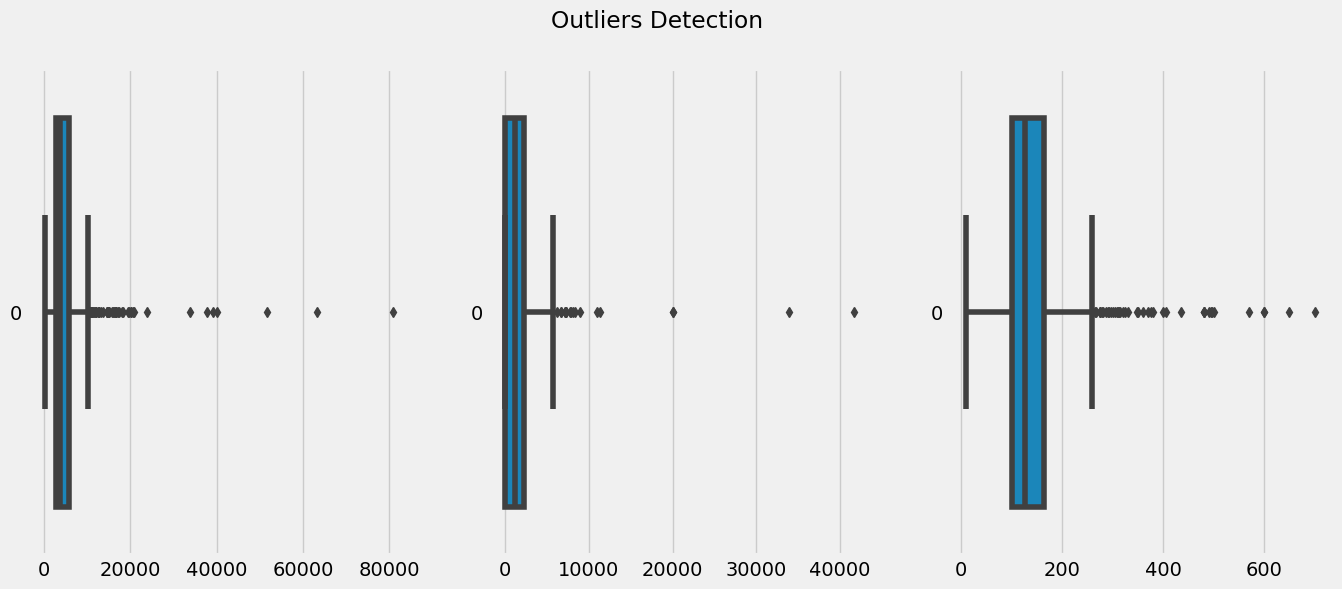

In [11]:
# Checking Outlier for numeric values
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 6)

plt.subplot(1, 3, 1)
sns.boxplot(data['ApplicantIncome'],orient='h')

plt.subplot(1, 3, 2)
sns.boxplot(data['CoapplicantIncome'],orient='h')

plt.subplot(1, 3, 3)
sns.boxplot(data['LoanAmount'],orient='h')

plt.suptitle("Outliers Detection")
plt.show()

In [12]:
#Split into Quantitaive and Qualitive
def Quan_Qual_data(data):
    Quan=[]
    Qual=[]
    for columns in data.columns:
        if data[columns].dtypes=='O':
            Qual.append(columns)
        else:
            Quan.append(columns)
    return Quan,Qual

In [13]:
Quan,Qual=Quan_Qual_data(data)

# Univariate

In [15]:
# This function will cover Mean,Median,Mode,Quartile,MinMax,Kurtosis,skew,variance,std
def Univariate(dataset,quan):
        descriptive=pd.DataFrame(index=["Mean","Median","Mode","Q1:25%","Q2:50%",
                                   "Q3:75%","99%","Q4:100%","IQR","1.5rule","Lesser","Greater","Min","Max"],columns=quan)
        for columnName in quan:
            descriptive[columnName]["Mean"]=dataset[columnName].mean()
            descriptive[columnName]["Median"]=dataset[columnName].median()
            descriptive[columnName]["Mode"]=dataset[columnName].mode()[0]
            descriptive[columnName]["Q1:25%"]=dataset.describe()[columnName]["25%"]
            descriptive[columnName]["Q2:50%"]=dataset.describe()[columnName]["50%"]
            descriptive[columnName]["Q3:75%"]=dataset.describe()[columnName]["75%"]
            descriptive[columnName]["99%"]=np.percentile(dataset[columnName],99)
            descriptive[columnName]["Q4:100%"]=dataset.describe()[columnName]["max"]
            descriptive[columnName]["IQR"]=descriptive[columnName]["Q3:75%"]-descriptive[columnName]["Q1:25%"]
            descriptive[columnName]["1.5rule"]=1.5*descriptive[columnName]["IQR"]
            descriptive[columnName]["Lesser"]=descriptive[columnName]["Q1:25%"]-descriptive[columnName]["1.5rule"]
            descriptive[columnName]["Greater"]=descriptive[columnName]["Q3:75%"]+descriptive[columnName]["1.5rule"]
            descriptive[columnName]["Min"]=dataset[columnName].min()
            descriptive[columnName]["Max"]=dataset[columnName].max()
            descriptive[columnName]["kurtosis"]=dataset[columnName].kurtosis()
            descriptive[columnName]["skew"]=dataset[columnName].skew()
            descriptive[columnName]["Var"]=dataset[columnName].var()
            descriptive[columnName]["Std"]=dataset[columnName].std()
        return descriptive

In [16]:
descriptive=Univariate(data,Quan)

In [17]:
descriptive

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Mean,5403.46,1621.25,145.681,342.41,0.855049
Median,3812.5,1188.5,126,360,1
Mode,2500,0,126,360,1
Q1:25%,2877.5,0,100.25,360,1
Q2:50%,3812.5,1188.5,126,360,1
Q3:75%,5795,2297.25,164.75,360,1
99%,32540.4,8895.89,495.87,480,1
Q4:100%,81000,41667,700,480,1
IQR,2917.5,2297.25,64.5,0,0
1.5rule,4376.25,3445.88,96.75,0,0


In [18]:
#Using Min/Max and Lesser/Greater value we can able to identify outliers
def check_outliers(Quan):
        Lesser = []
        Greater = []

        for column_name in Quan:
            if descriptive[column_name]['Min'] < descriptive[column_name]['Lesser']:
                Lesser.append(column_name)
            if descriptive[column_name]['Max'] > descriptive[column_name]['Greater']:
                Greater.append(column_name)
        return Lesser, Greater

In [19]:
Lesser,Greater=check_outliers(Quan)

In [20]:
Lesser

['Loan_Amount_Term', 'Credit_History']

In [21]:
Greater

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [22]:
# Replace the Outliers
def replace_outliers(Lesser, Greater):
    for column_name in Lesser:
        data[column_name][data[column_name] < descriptive[column_name]['Lesser']] = descriptive[column_name]['Lesser']

    for column_name in Greater:
        data[column_name][data[column_name] > descriptive[column_name]['Greater']] = descriptive[column_name]['Greater']

    return descriptive

In [23]:
descriptive=replace_outliers(Lesser,Greater)

In [24]:
def Univariate(dataset,quan):
        descriptive=pd.DataFrame(index=["Mean","Median","Mode","Q1:25%","Q2:50%",
                                   "Q3:75%","99%","Q4:100%","IQR","1.5rule","Lesser","Greater","Min","Max"],columns=quan)
        for columnName in quan:
            descriptive[columnName]["Mean"]=dataset[columnName].mean()
            descriptive[columnName]["Median"]=dataset[columnName].median()
            descriptive[columnName]["Mode"]=dataset[columnName].mode()[0]
            descriptive[columnName]["Q1:25%"]=dataset.describe()[columnName]["25%"]
            descriptive[columnName]["Q2:50%"]=dataset.describe()[columnName]["50%"]
            descriptive[columnName]["Q3:75%"]=dataset.describe()[columnName]["75%"]
            descriptive[columnName]["99%"]=np.percentile(dataset[columnName],99)
            descriptive[columnName]["Q4:100%"]=dataset.describe()[columnName]["max"]
            descriptive[columnName]["IQR"]=descriptive[columnName]["Q3:75%"]-descriptive[columnName]["Q1:25%"]
            descriptive[columnName]["1.5rule"]=1.5*descriptive[columnName]["IQR"]
            descriptive[columnName]["Lesser"]=descriptive[columnName]["Q1:25%"]-descriptive[columnName]["1.5rule"]
            descriptive[columnName]["Greater"]=descriptive[columnName]["Q3:75%"]+descriptive[columnName]["1.5rule"]
            descriptive[columnName]["Min"]=dataset[columnName].min()
            descriptive[columnName]["Max"]=dataset[columnName].max()
            descriptive[columnName]["kurtosis"]=dataset[columnName].kurtosis()
            descriptive[columnName]["skew"]=dataset[columnName].skew()
            descriptive[columnName]["Var"]=dataset[columnName].var()
            descriptive[columnName]["Std"]=dataset[columnName].std()
        return descriptive

In [25]:
descriptive=Univariate(data,Quan)

In [26]:
descriptive  # We replaced the minimum value with lesser outlier and Maximum value with Greater outlier so all the values between Lesser and Greater Outlier

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Mean,4617.11,1419.7,137.294,360,1
Median,3812.5,1188.5,126,360,1
Mode,10171.2,0,261.5,360,1
Q1:25%,2877.5,0,100.25,360,1
Q2:50%,3812.5,1188.5,126,360,1
Q3:75%,5795,2297.25,164.75,360,1
99%,10171.2,5743.12,261.5,360,1
Q4:100%,10171.2,5743.12,261.5,360,1
IQR,2917.5,2297.25,64.5,0,0
1.5rule,4376.25,3445.88,96.75,0,0


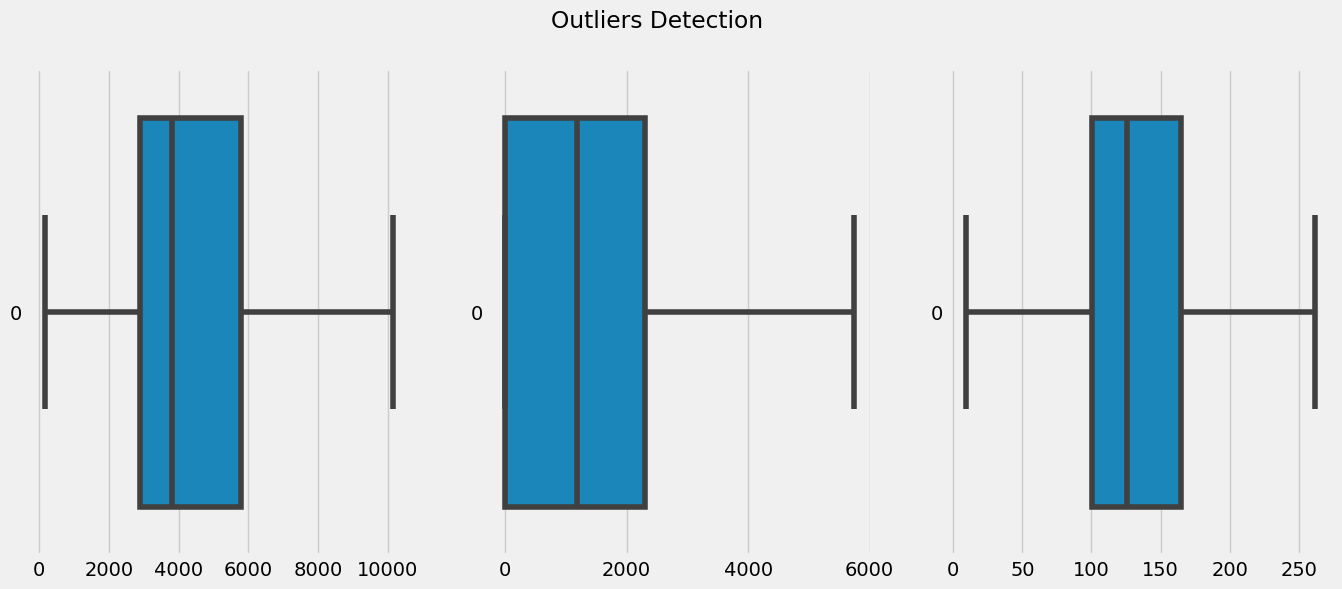

In [30]:
# Rechecking Outlier for numeric values
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 6)

plt.subplot(1, 3, 1)
sns.boxplot(data['ApplicantIncome'],orient='h')

plt.subplot(1, 3, 2)
sns.boxplot(data['CoapplicantIncome'],orient='h')

plt.subplot(1, 3, 3)
sns.boxplot(data['LoanAmount'],orient='h')

plt.suptitle("Outliers Detection")
plt.show()

## Distribution and Standard Normal Distribution

C:\Users\Arun\anaconda3\envs\aiml\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
C:\Users\Arun\anaconda3\envs\aiml\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """
C:\Users\Arun\anaconda3\envs\aiml\lib\site-packages\ipykernel_launcher.

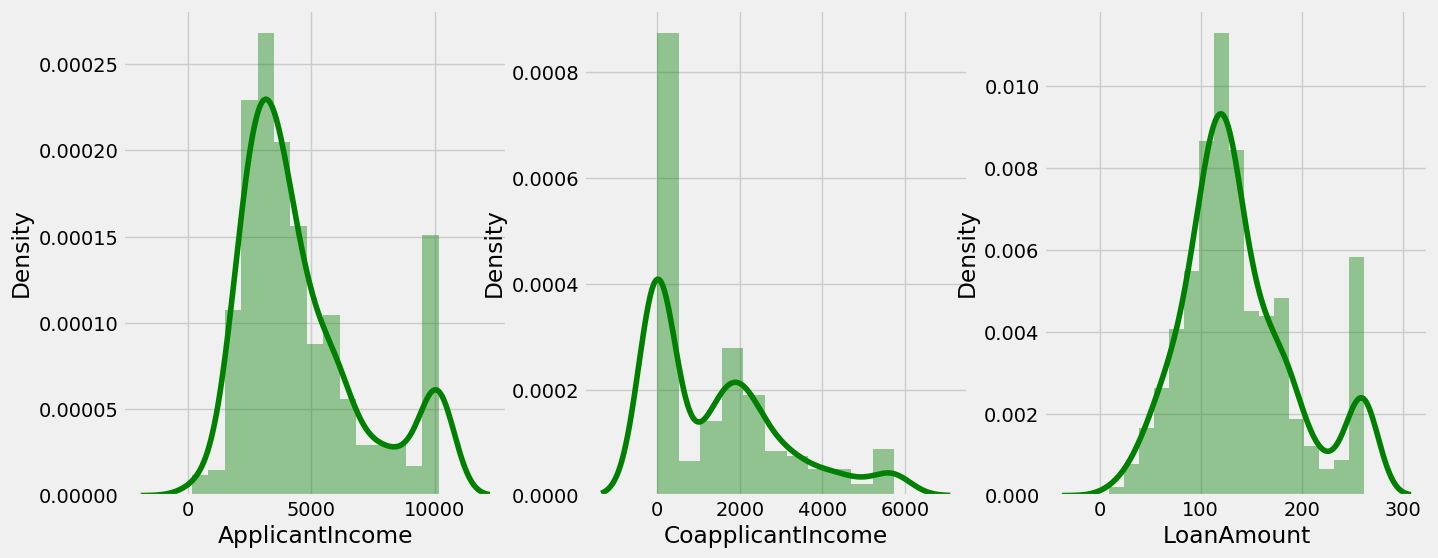

In [31]:
plt.subplot(1, 3, 1)
sns.distplot(data['ApplicantIncome'], color = 'green')

plt.subplot(1, 3, 2)
sns.distplot(data['CoapplicantIncome'], color = 'green')

plt.subplot(1, 3, 3)
sns.distplot(data['LoanAmount'], color = 'green')

C:\Users\Arun\anaconda3\envs\aiml\lib\site-packages\ipykernel_launcher.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  app.launch_new_instance()
C:\Users\Arun\anaconda3\envs\aiml\lib\site-packages\ipykernel_launcher.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  app.launch_new_instance()
C:\Users\Arun\anaconda

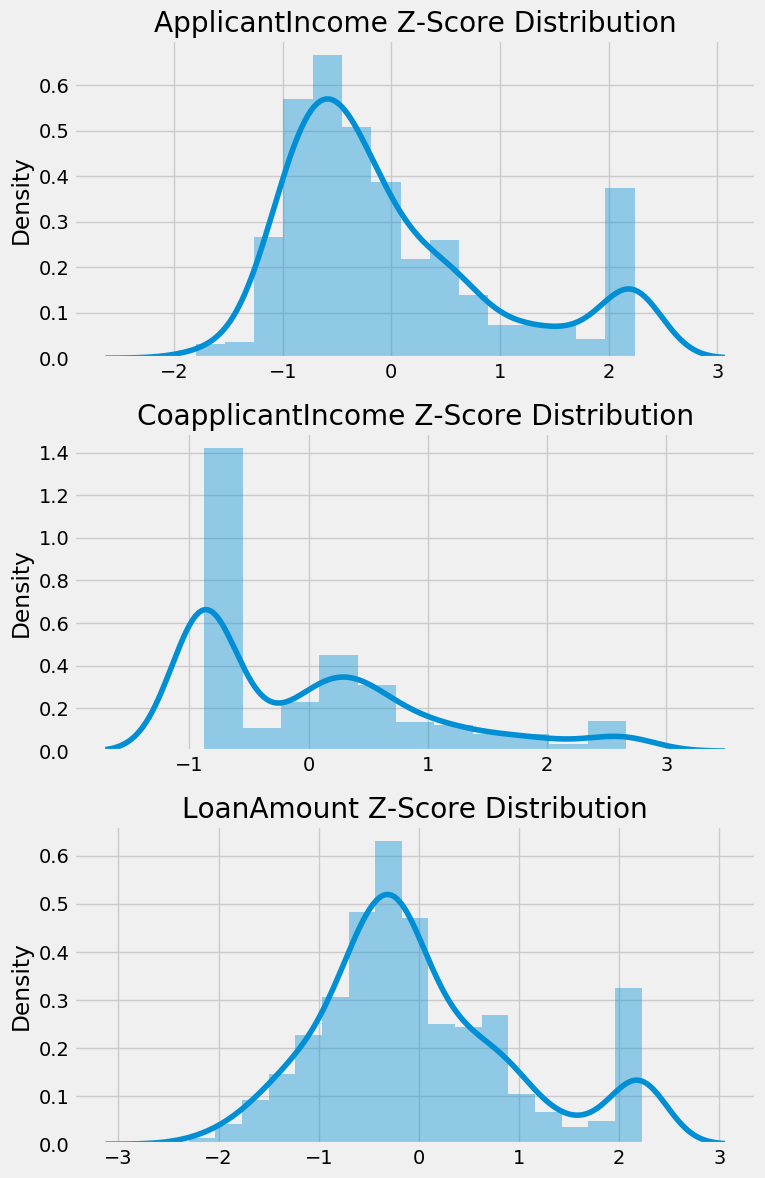

In [32]:
## Standard Normal Distribution (Z score distribuion for all 3 numerical feature)

def std_graph(data):
    # Calculate mean and standard deviation for each feature
    mean_values = data.mean()
    std_values = data.std()

    # Create subplots for each feature
    num_features = len(data.columns)
    fig, axes = plt.subplots(nrows=num_features, figsize=(8, 4 * num_features))

    # Iterate through each feature and plot its z-scores
    for i, feature in enumerate(data.columns):
        values = list(data[feature])
        z_scores = [(X - mean_values[feature]) / std_values[feature] for X in values]

        sns.distplot(z_scores, kde=True, ax=axes[i])
        axes[i].set_title(f'{feature} Z-Score Distribution')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()
std_graph(data[['ApplicantIncome','CoapplicantIncome','LoanAmount']])

In [ ]:
features=['Dependents',
 'Education',
 'Gender',
 'Loan_Status',
 'Married',
 'Property_Area',
 'Self_Employed']
for i in features:
    plt.figure(figsize = (15,10))
   # plt.subplot(1,3,2)
    sns.countplot(x =i, hue = 'Loan_Status', data = data, palette = 'plasma' )
    plt.xlabel(i, fontsize = 15)

Create count plots for each of the features, including 'Dependents,' 'Education,' 'Gender,' 'Married,' 'Property_Area,' and 'Self_Employed,' with loan approval status as the hue. The colors in the count plots will help differentiate between approved and non-approved loans for each specific feature

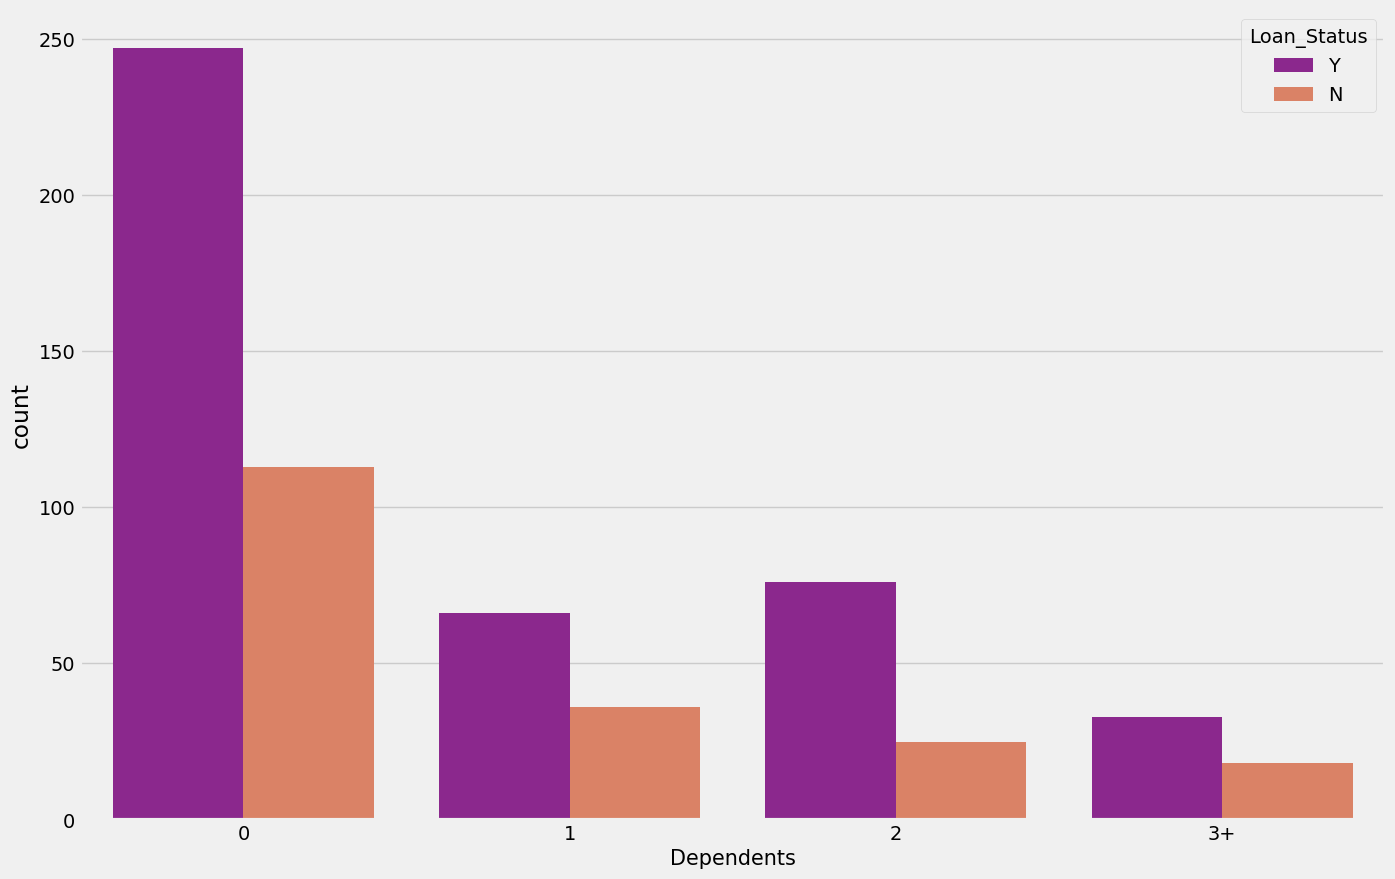

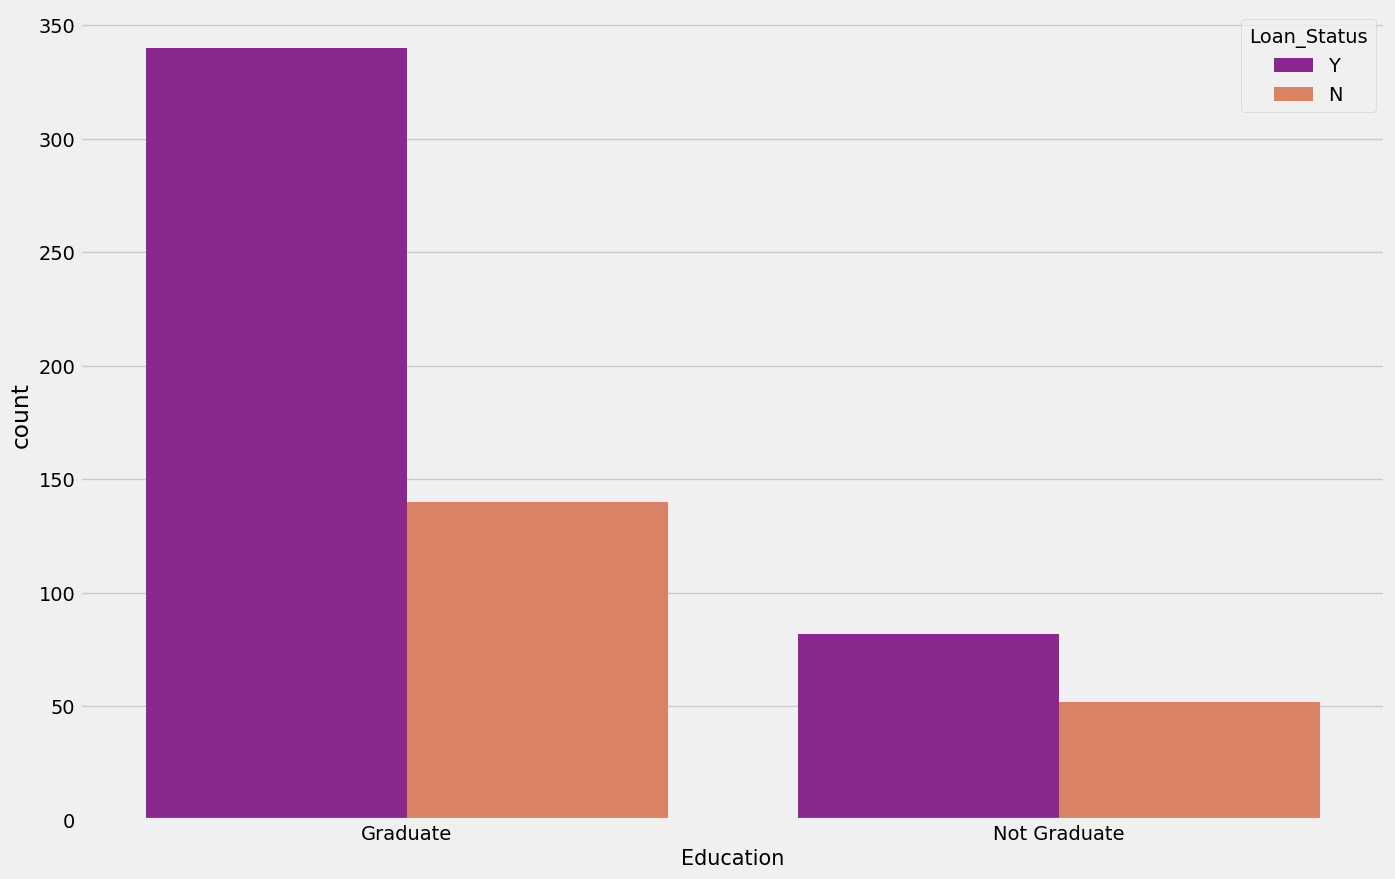

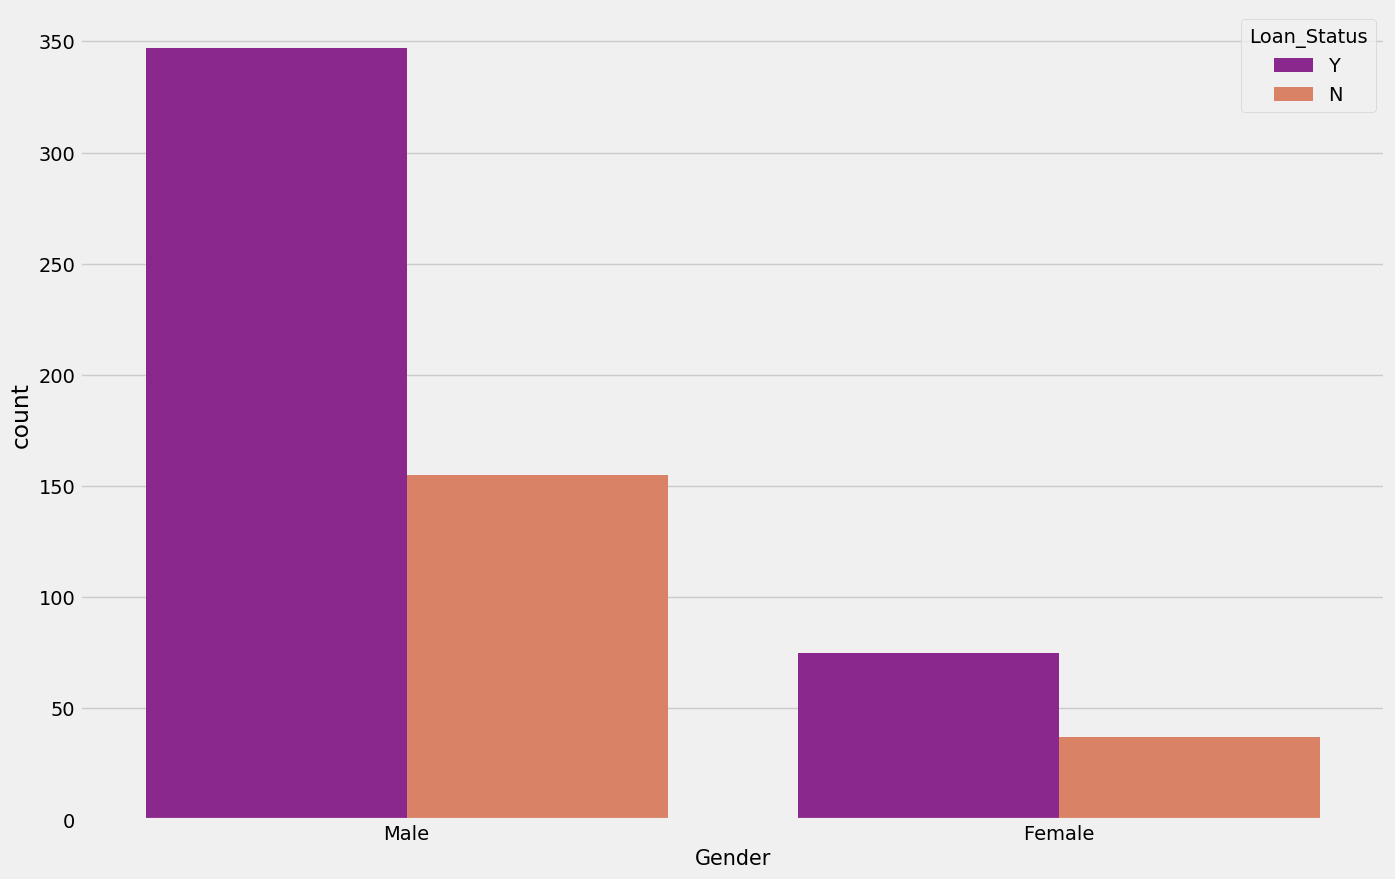

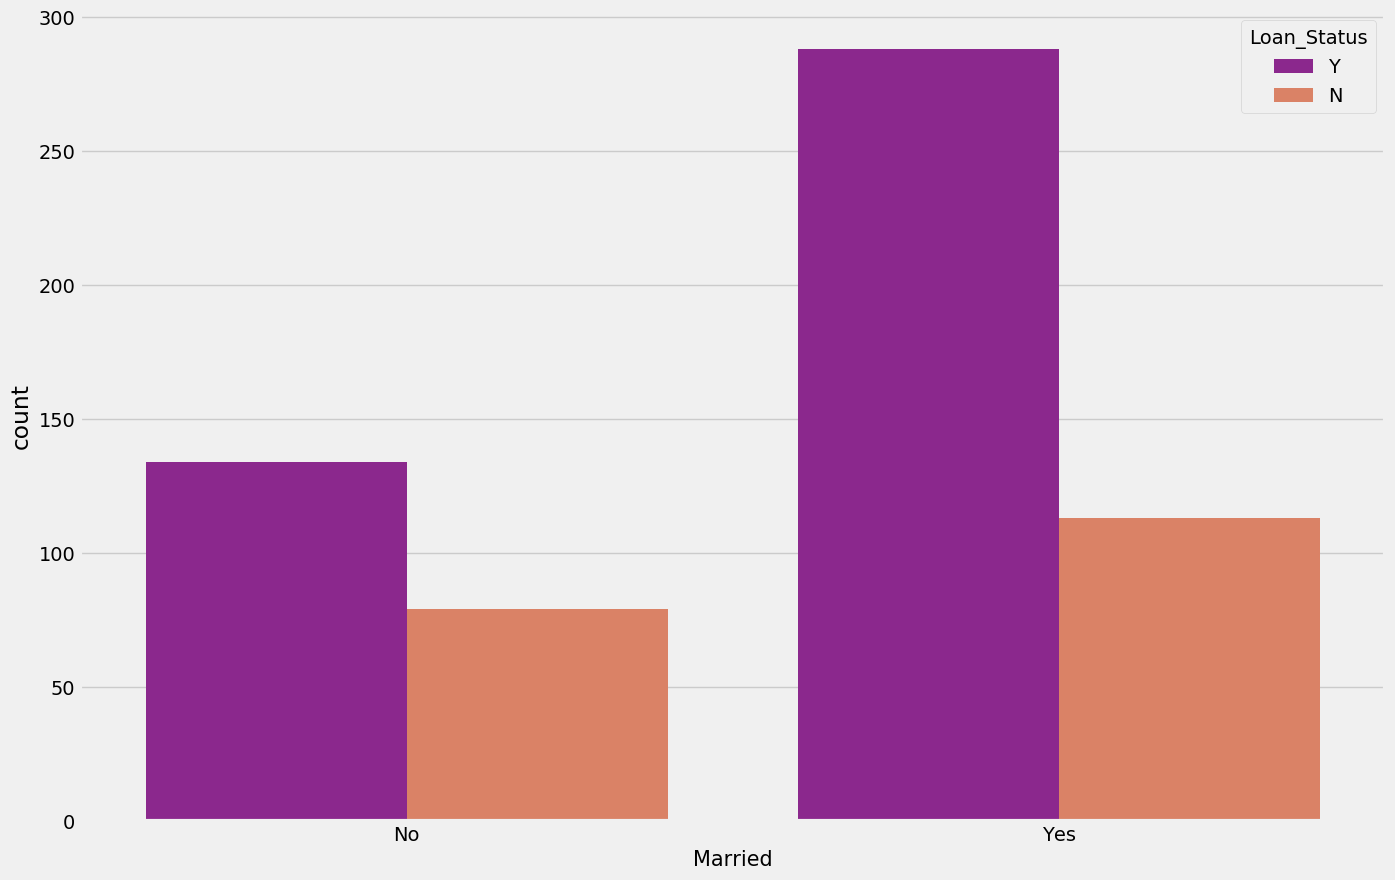

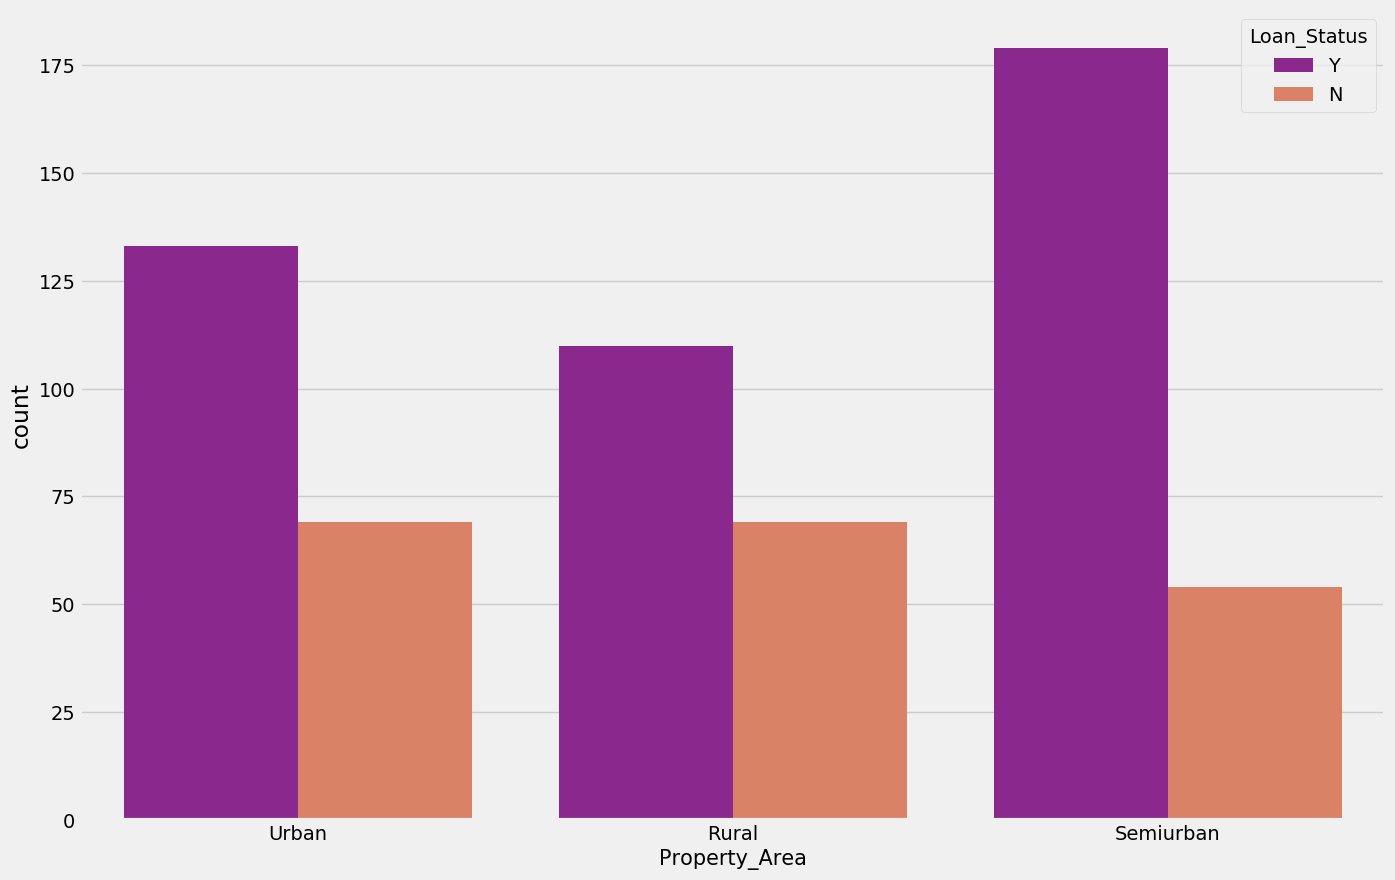

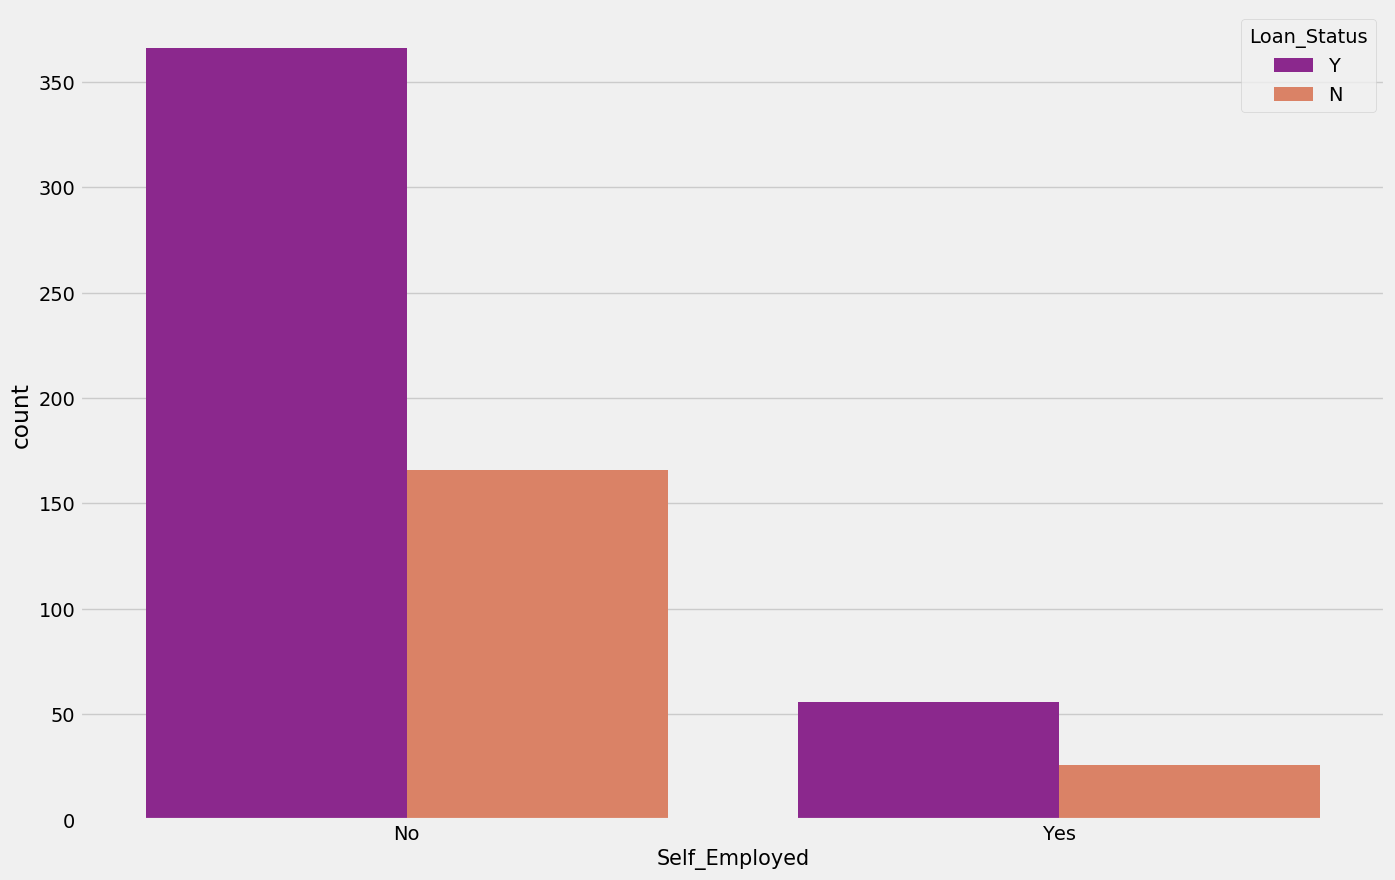

In [33]:
features=['Dependents',
 'Education',
 'Gender',
 'Married',
 'Property_Area',
 'Self_Employed']
for i in features:
    plt.figure(figsize = (15,10))
   # plt.subplot(1,3,2)
    sns.countplot(x =i, hue = 'Loan_Status', data = data, palette = 'plasma' )
    plt.xlabel(i, fontsize = 15)

In [44]:
# To checkit in cross tab
print(pd.crosstab(data['Loan_Status'], data['Married'], margins=True, margins_name='Total'))
print('\n')
print(pd.crosstab(data['Loan_Status'], data['Education'], margins=True, margins_name='Total'))
print('\n')
print(pd.crosstab(data['Loan_Status'], data['Property_Area'], margins=True, margins_name='Total'))
print('\n')
print(pd.crosstab(data['Loan_Status'], data['Self_Employed'], margins=True, margins_name='Total'))


Married       No  Yes  Total
Loan_Status                 
N             79  113    192
Y            134  288    422
Total        213  401    614


Education    Graduate  Not Graduate  Total
Loan_Status                               
N                 140            52    192
Y                 340            82    422
Total             480           134    614


Property_Area  Rural  Semiurban  Urban  Total
Loan_Status                                  
N                 69         54     69    192
Y                110        179    133    422
Total            179        233    202    614


Self_Employed   No  Yes  Total
Loan_Status                   
N              166   26    192
Y              366   56    422
Total          532   82    614


# Bivariate

In [45]:
data[['ApplicantIncome','CoapplicantIncome','LoanAmount']].cov()

,ApplicantIncome,CoapplicantIncome,LoanAmount
ApplicantIncome,6.149665e+06,-9.224141e+05,77169.845616
CoapplicantIncome,-9.224141e+05,2.639344e+06,24043.107541
LoanAmount,7.716985e+04,2.404311e+04,3112.863275


- covariance values are influenced by the scale of the variables, and it can be challenging to compare covariances directly. If you want a standardized measure that is easier to compare, you may consider the correlation coefficient, which normalizes the covariance by the standard deviations of the variables.

In [46]:
data[['ApplicantIncome','CoapplicantIncome','LoanAmount']].corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount
ApplicantIncome,1.000000,-0.228956,0.557753
CoapplicantIncome,-0.228956,1.000000,0.265254
LoanAmount,0.557753,0.265254,1.000000


- There is a weak negative correlation between ApplicantIncome and CoapplicantIncome.
- There is a moderate positive correlation between ApplicantIncome and LoanAmount.
- There is a weak positive correlation between CoapplicantIncome and LoanAmount.

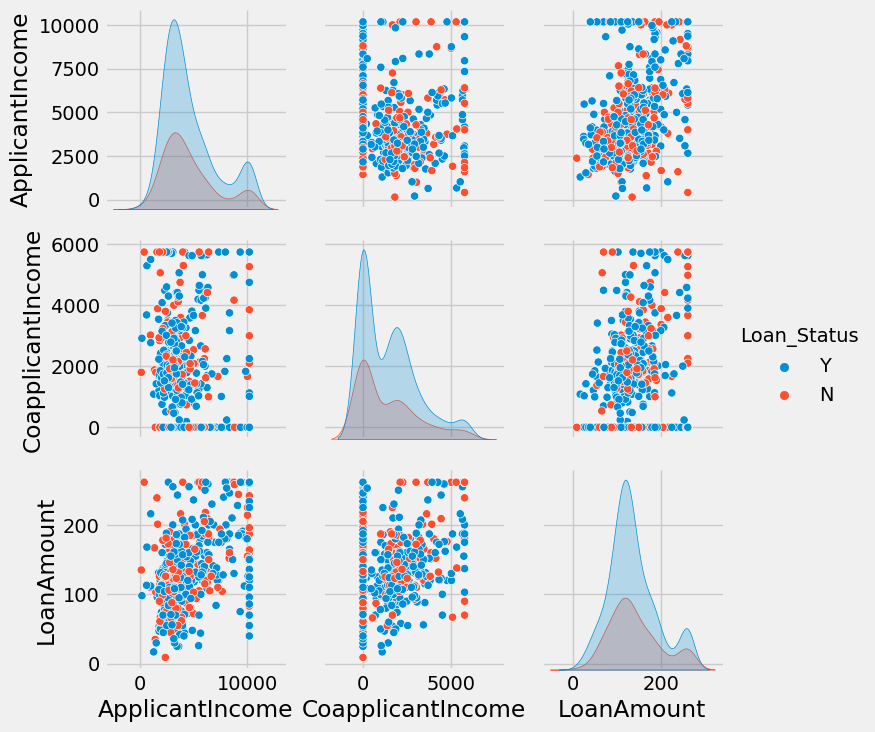

In [48]:
# visualize the pair to check multicollinearity

sns.pairplot(data[['ApplicantIncome','CoapplicantIncome','LoanAmount'] + ['Loan_Status']], hue='Loan_Status')
plt.show()


In [50]:
# Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calc_vif(data_frame):
    variables = data_frame.columns
    vif_data = pd.DataFrame()
    vif_data["Variable"] = variables
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data
calc_vif(data[Quan])

C:\Users\Arun\anaconda3\envs\aiml\lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,ApplicantIncome,1.865307
1,CoapplicantIncome,1.382290
2,LoanAmount,1.901302
3,Loan_Amount_Term,0.000000
4,Credit_History,0.000000


VIF values close to 1 indicate low multicollinearity.
VIF values between 1 and 5 suggest moderate multicollinearity.
VIF values above 5 indicate high multicollinearity, and values above 10 are a cause for concern.

Based on the provided VIF values:

ApplicantIncome: VIF = 1.87 (Moderate multicollinearity)
CoapplicantIncome: VIF = 1.38 (Low multicollinearity)
LoanAmount: VIF = 1.90 (Moderate multicollinearity)
Loan_Amount_Term: VIF = 0 (No multicollinearity)
Credit_History: VIF = 0 (No multicollinearity)

## Ttest or Anova test when input has numerical and Target has Categorical or Input has categoricl and Target has numerical

In [51]:
## Input has numerical and Target has Categorical

from scipy.stats import ttest_ind

# Split the data into two groups based on Loan_Status
loan_status_yes = data[data['Loan_Status'] == 'Y']
loan_status_no = data[data['Loan_Status'] == 'N']

# Perform t-test for each numerical feature
for feature in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
    t_stat, p_value = ttest_ind(loan_status_yes[feature], loan_status_no[feature])
    
    print(f"\nT-test for {feature}:")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        print("Reject the null hypothesis. There is a significant difference.")
    else:
        print("Fail to reject the null hypothesis. No significant difference.")



T-test for ApplicantIncome:
T-statistic: -0.010937416980115305
P-value: 0.9912769421981265
Fail to reject the null hypothesis. No significant difference.

T-test for CoapplicantIncome:
T-statistic: 0.2964606397999629
P-value: 0.7669788988824243
Fail to reject the null hypothesis. No significant difference.

T-test for LoanAmount:
T-statistic: -1.1573429579250278
P-value: 0.24758376796902018
Fail to reject the null hypothesis. No significant difference.


# Chi Square Test when Input and target is categorical

In [52]:
from scipy.stats import chi2_contingency

categorical_features = ['Dependents', 'Education', 'Gender', 'Married', 'Property_Area', 'Self_Employed']

for feature in categorical_features:
    contingency_table = pd.crosstab(data[feature], data['Loan_Status'])
    
    # Perform chi-square test
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Check p-value
    print(f"\nChi-square test for {feature}:")
    print(f"Chi2 value: {chi2}")
    print(f"P-value: {p}")
    
    if p < 0.05:
        print("Reject the null hypothesis. There is a significant association.")
    else:
        print("Fail to reject the null hypothesis. No significant association.")



Chi-square test for Dependents:
Chi2 value: 3.1513990012324227
P-value: 0.3688663081366005
Fail to reject the null hypothesis. No significant association.

Chi-square test for Education:
Chi2 value: 4.091490413303621
P-value: 0.04309962129357355
Reject the null hypothesis. There is a significant association.

Chi-square test for Gender:
Chi2 value: 0.11087854691241235
P-value: 0.7391461310869638
Fail to reject the null hypothesis. No significant association.

Chi-square test for Married:
Chi2 value: 4.73187557933362
P-value: 0.029608580862582116
Reject the null hypothesis. There is a significant association.

Chi-square test for Property_Area:
Chi2 value: 12.297623130485675
P-value: 0.0021360187811644937
Reject the null hypothesis. There is a significant association.

Chi-square test for Self_Employed:
Chi2 value: 0.0
P-value: 1.0
Fail to reject the null hypothesis. No significant association.


- significant difference between Education, Married, and Property_Area variables, while no significant associations were found for Dependents, Gender, and Self_Employed variables.

# Ttest or Anova test when input has numerical and Target has Categorical or Input has categoricl and Target has numerical

In [54]:
from scipy.stats import f_oneway

# Perform ANOVA for each numerical feature
for feature in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
    groups = [data[data['Loan_Status'] == status][feature] for status in data['Loan_Status'].unique()]
    
    f_stat, p_value = f_oneway(*groups)
    
    print(f"\nANOVA for {feature}:")
    print(f"F-statistic: {f_stat}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        print("Reject the null hypothesis. There is a significant difference.")
    else:
        print("Fail to reject the null hypothesis. No significant difference.")



ANOVA for ApplicantIncome:
F-statistic: 0.00011962709019694214
P-value: 0.9912769421990383
Fail to reject the null hypothesis. No significant difference.

ANOVA for CoapplicantIncome:
F-statistic: 0.08788891095060343
P-value: 0.7669788988824301
Fail to reject the null hypothesis. No significant difference.

ANOVA for LoanAmount:
F-statistic: 1.3394427222586462
P-value: 0.24758376796904907
Fail to reject the null hypothesis. No significant difference.


- there is no strong evidence of a significant difference between the groups with different Loan_Status values for these numerical features.